In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

In [2]:
spark = SparkSession.builder.appName("Spark_Joins") \
                    .config("spark.sql.warehouse.dir","/users/itv012857/warehouse") \
                    .enableHiveSupport() \
                    .master("yarn") \
                    .getOrCreate()

In [3]:
order_schema = StructType(
                            [ StructField("order_id", IntegerType(), False),
                              StructField("order_date", DateType(), False),
                              StructField("customer_id", IntegerType(), False),
                              StructField("order_status", StringType(), False)
                            ]
                        )

In [4]:
orders_df = spark.read.csv("/public/trendytech/orders/orders_1gb.csv", schema = order_schema)

In [5]:
orders_df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- order_status: string (nullable = true)



In [6]:
orders_df.show()

+--------+----------+-----------+---------------+
|order_id|order_date|customer_id|   order_status|
+--------+----------+-----------+---------------+
|       1|2013-07-25|      11599|         CLOSED|
|       2|2013-07-25|        256|PENDING_PAYMENT|
|       3|2013-07-25|      12111|       COMPLETE|
|       4|2013-07-25|       8827|         CLOSED|
|       5|2013-07-25|      11318|       COMPLETE|
|       6|2013-07-25|       7130|       COMPLETE|
|       7|2013-07-25|       4530|       COMPLETE|
|       8|2013-07-25|       2911|     PROCESSING|
|       9|2013-07-25|       5657|PENDING_PAYMENT|
|      10|2013-07-25|       5648|PENDING_PAYMENT|
|      11|2013-07-25|        918| PAYMENT_REVIEW|
|      12|2013-07-25|       1837|         CLOSED|
|      13|2013-07-25|       9149|PENDING_PAYMENT|
|      14|2013-07-25|       9842|     PROCESSING|
|      15|2013-07-25|       2568|       COMPLETE|
|      16|2013-07-25|       7276|PENDING_PAYMENT|
|      17|2013-07-25|       2667|       COMPLETE|


In [7]:
orders_df.rdd.getNumPartitions()

9

In [11]:
customer_schema = StructType(
                            [ StructField("customer_id", IntegerType(), False),
                              StructField("first_name", StringType(), False),
                              StructField("last_name", StringType(), False),
                              StructField("email", StringType(), False),
                              StructField("password", StringType(), False),
                              StructField("street", StringType(), False),
                              StructField("city", StringType(), False),
                              StructField("state", StringType(), False),
                              StructField("zipcode", IntegerType(), False)
                            ]
                        )

In [12]:
cust_df = spark.read.csv("/public/trendytech/retail_db/customers", schema=customer_schema )

In [13]:
cust_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- password: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipcode: integer (nullable = true)



In [14]:
cust_df.show()

+-----------+-----------+---------+---------+---------+--------------------+-------------+-----+-------+
|customer_id| first_name|last_name|    email| password|              street|         city|state|zipcode|
+-----------+-----------+---------+---------+---------+--------------------+-------------+-----+-------+
|          1|    Richard|Hernandez|XXXXXXXXX|XXXXXXXXX|  6303 Heather Plaza|  Brownsville|   TX|  78521|
|          2|       Mary|  Barrett|XXXXXXXXX|XXXXXXXXX|9526 Noble Embers...|    Littleton|   CO|  80126|
|          3|        Ann|    Smith|XXXXXXXXX|XXXXXXXXX|3422 Blue Pioneer...|       Caguas|   PR|    725|
|          4|       Mary|    Jones|XXXXXXXXX|XXXXXXXXX|  8324 Little Common|   San Marcos|   CA|  92069|
|          5|     Robert|   Hudson|XXXXXXXXX|XXXXXXXXX|10 Crystal River ...|       Caguas|   PR|    725|
|          6|       Mary|    Smith|XXXXXXXXX|XXXXXXXXX|3151 Sleepy Quail...|      Passaic|   NJ|   7055|
|          7|    Melissa|   Wilcox|XXXXXXXXX|XXXXXXXXX|

In [15]:
cust_df.count()

12435

In [16]:
cust_df.rdd.getNumPartitions()

1

In [ ]:
orders_df.join(cust_df,orders_df.customer_id == cust_df.customer_id, "inner").write.mode("overwrite").format("noop").save()

Since the Cust DF is smaller than autoBroadcastJoinThreshold a Broadcast Hash Join was done by Spark. <br>
9 Tasks were created corresponding to the 9 Partitions of orders_df. <br>
A hash table of Cust DF created and loaded to the driver memory and then the driver broadcasted it to all the 9 executors. <br>
Finally a Broadcast hash join took place using the orders_df partitions and cust_df hash table. <BR>
Took total 37 secs

In [17]:
spark.conf.get("spark.sql.autoBroadcastJoinThreshold")

'10485760b'

In [18]:
10485760/(1024*1024)

10.0

In [19]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

In [20]:
spark.conf.get("spark.sql.autoBroadcastJoinThreshold")

'-1'

In [23]:
orders_df.join(cust_df,orders_df.customer_id == cust_df.customer_id, "inner").write.mode("overwrite").format("noop").save()

Shuffle sort merge join was implemented by Spark as the autoBroadcastJoinThreshold is set to -1. <BR>
This will be implemented by default if the size of both the tables > 10 MB. <BR>
Took 1.6 mins

In [22]:
orders_df.join(cust_df.hint("shuffle_hash"),orders_df.customer_id == cust_df.customer_id, "inner").write.mode("overwrite").format("noop").save()

Shuffle Hash join is implemented as we have given hint to implement Shuffle Hash Join. This took 1.4 mins.

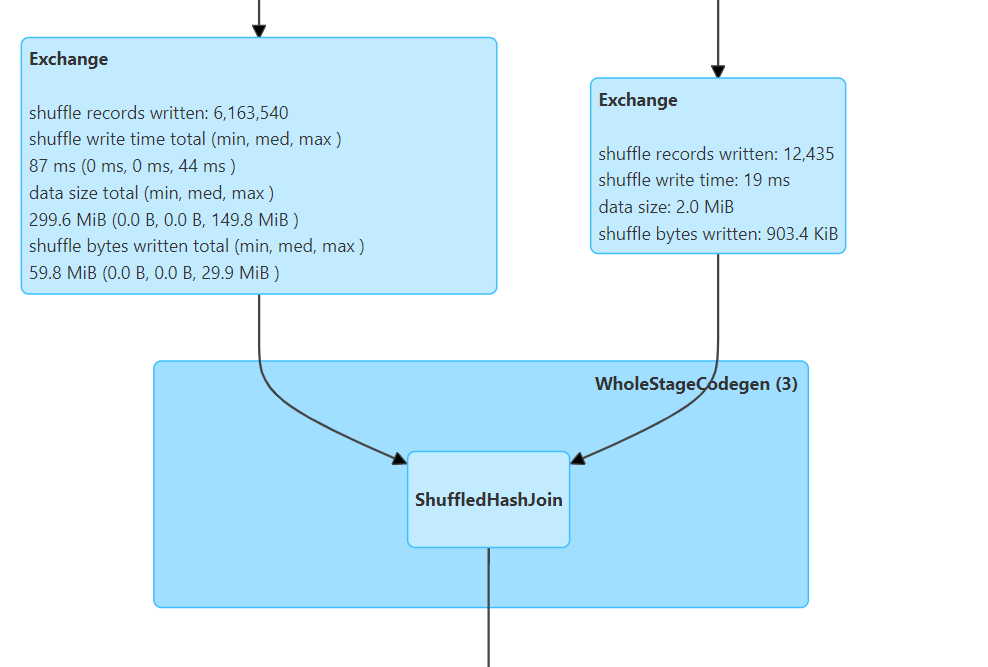

In [25]:
# Enabling Adaptive Query Execution (AQE)

spark.conf.get("spark.sql.adaptive.enabled")

'false'

In [34]:
spark.conf.set("spark.sql.adaptive.enabled","true")

In [35]:
spark.conf.get("spark.sql.adaptive.enabled")

'true'

In [36]:
orders_df.join(cust_df,orders_df.customer_id == cust_df.customer_id, "inner").write.mode("overwrite").format("noop").save()

Instead of 210-215 tasks, only 11 task are created as AQE is enabled. <BR>
Executed in 48 secs.

In [39]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold","10485760b")

Left Join Demo

In [40]:
orders_df.join(cust_df,orders_df.customer_id == cust_df.customer_id, "left").show()

+--------+----------+-----------+---------------+-----------+----------+---------+---------+---------+--------------------+-------------+-----+-------+
|order_id|order_date|customer_id|   order_status|customer_id|first_name|last_name|    email| password|              street|         city|state|zipcode|
+--------+----------+-----------+---------------+-----------+----------+---------+---------+---------+--------------------+-------------+-----+-------+
|       1|2013-07-25|      11599|         CLOSED|      11599|      Mary|   Malone|XXXXXXXXX|XXXXXXXXX|8708 Indian Horse...|      Hickory|   NC|  28601|
|       2|2013-07-25|        256|PENDING_PAYMENT|        256|     David|Rodriguez|XXXXXXXXX|XXXXXXXXX|7605 Tawny Horse ...|      Chicago|   IL|  60625|
|       3|2013-07-25|      12111|       COMPLETE|      12111|     Amber|   Franco|XXXXXXXXX|XXXXXXXXX|8766 Clear Prairi...|   Santa Cruz|   CA|  95060|
|       4|2013-07-25|       8827|         CLOSED|       8827|     Brian|   Wilson|XXXXXX

In [ ]:
Left Semi or S

In [ ]:
cust_df.join(orders_df,orders_df.customer_id == cust_df.customer_id, "semi").show()